In [1]:
import os
from fnmatch import fnmatch
import pandas as pd
import re
import tqdm
import plotnine as p9
import patchworklib as pw
import numpy as np

<Figure size 72x72 with 0 Axes>

In [2]:
def dict_from_path(path: str):
    params_name_pattern = "([a-zA-Z]*)-"
    param_names = [path[m.start():m.end()-1] for m in re.finditer(params_name_pattern, path)]
    dict = {}
    for param in param_names:
        dict[param] = 0
    return dict

In [3]:
def construct_regex_string(path: str, names: dict):
    res: str = ""
    last_key = list(names.keys())[-1]
    for key in list(names.keys()):
        res = res + key + "-([0-9.]*)"
        if key != last_key:
            res = res + '_'
    return res

In [4]:
def extract_parms(filepath: str):
    param_st = filepath.split('/')[-2]
    params = dict_from_path(param_st)
    regex_str = construct_regex_string(param_st, params)
    result = re.search(regex_str, param_st)
    keys = list(params.keys())
    for x, key in enumerate(keys):
        params[key] = float(result.group(x+1))
    return params

In [5]:
root = os.path.join(os.getcwd(),'output_well_mixed_static')
pattern = "logger_6_Ve.csv"
file_paths = []
dfsV = []

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            file_path = os.path.join(path, name)
            file_paths.append(file_path)
            df = pd.read_csv(file_path, sep='\t')
            params = extract_parms(file_path)
            for key in list(params.keys()):
                df[key] = params[key]
            dfsV.append(df)

In [6]:
simV = pd.concat(dfsV)
simV = simV[simV["10"] != 10]
simV['time'] = np.tile(np.repeat(range(0,51),10),int(len(simV.index)/510))
simV['sum_V_x'] = simV.iloc[:, 1:11].sum(axis=1)
simV = simV.drop(columns=[str(x) for x in range(0,11)])
simV = simV.groupby(list(simV.columns[:-1])).agg({'sum_V_x': 'sum'}).reset_index()
simV['cv_cat'] = simV['cv'].astype("category")
simV

,DV,bcf,pi,cv,time,sum_V_x,cv_cat
0,999.0,0.001,0.01,0.05,0,0.0,0.05
1,999.0,0.001,0.01,0.05,1,0.0,0.05
2,999.0,0.001,0.01,0.05,2,0.0,0.05
3,999.0,0.001,0.01,0.05,3,0.0,0.05
4,999.0,0.001,0.01,0.05,4,0.0,0.05
...,...,...,...,...,...,...,...
6115,999.0,1.000,1.00,1.00,46,87.0,1.00
6116,999.0,1.000,1.00,1.00,47,87.0,1.00
6117,999.0,1.000,1.00,1.00,48,87.0,1.00
6118,999.0,1.000,1.00,1.00,49,87.0,1.00


In [7]:
timesteps=50
def calculate_V(df: pd.DataFrame):
    df = df[df["10"]!=10]
    morpheus_ts = np.repeat(range(0,timesteps+1),10)
    df["time"] = np.tile(morpheus_ts,int(len(df.index)/morpheus_ts.shape[0]))
    df['sum_V'] = df.iloc[:, 1:11].sum(axis=1)
    df = df.drop(columns=[str(x) for x in range(0,11)])
    df = df.groupby(list(df.columns[:-1])).agg({'sum_V': 'sum'}).reset_index()
    return df

In [8]:
plots_V = []
for dv in simV['DV'].unique():
    plot = (p9.ggplot(simV[simV['DV'] == dv], p9.aes(x='time', color='cv_cat'))
            + p9.geom_line(p9.aes(y='sum_V_x'))
            + p9.facet_grid('bcf ~ pi', labeller = 'label_both')
            + p9.labs(title="DV: " + str(dv))
            )
    plots_V.append(pw.load_ggplot(plot))
print("nr of plots: " + str(len(simV['DV'].unique())))

nr of plots: 1


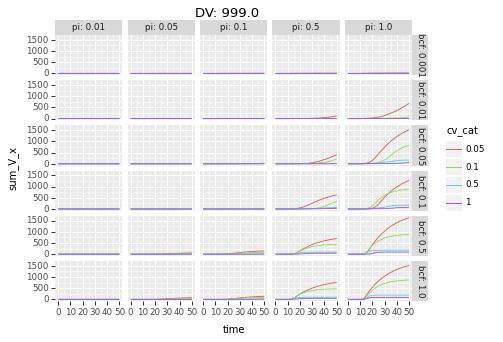

In [9]:
figure = plots_V[0]
figure.savefig()

In [10]:
root = os.path.join(os.getcwd(),'output_well_mixed_static')
pattern = "logger_2.csv"
file_paths = []
dfs = []

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            file_path = os.path.join(path, name)
            file_paths.append(file_path)
            df = pd.read_csv(file_path, sep='\t')
            params = extract_parms(file_path)
            for key in list(params.keys()):
                df[key] = params[key]
            dfs.append(df)

In [11]:
pd.concat(dfs)

,time,celltype.target.size,celltype.infected.size,DV,bcf,pi,cv
0,0,49,1,999.0,0.100,0.05,0.5
1,1,49,1,999.0,0.100,0.05,0.5
2,2,49,1,999.0,0.100,0.05,0.5
3,3,49,1,999.0,0.100,0.05,0.5
4,4,49,1,999.0,0.100,0.05,0.5
...,...,...,...,...,...,...,...
46,46,49,1,999.0,0.001,0.01,1.0
47,47,49,1,999.0,0.001,0.01,1.0
48,48,49,1,999.0,0.001,0.01,1.0
49,49,49,1,999.0,0.001,0.01,1.0


In [12]:
sim = pd.concat(dfs)
sim = sim[sim['time'] >= 10]
sim['cv_cat'] = sim['cv'].astype("category")

In [13]:
plots = []
for dv in sim['DV'].unique():
    plot = (p9.ggplot(sim[sim['DV'] == dv], p9.aes(x='time', color='cv_cat'))
            + p9.geom_line(p9.aes(y='celltype.infected.size'))
            + p9.facet_grid('bcf ~ pi', labeller = 'label_both')
            + p9.labs(title="DV: " + str(dv))
            )
    plots.append(pw.load_ggplot(plot))
print("nr of plots: " + str(len(sim['DV'].unique())))

nr of plots: 1


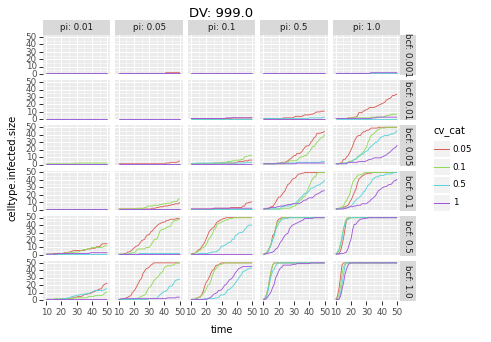

In [14]:
figure = plots[0]
figure.savefig()

In [15]:
root = os.path.join(os.getcwd(),'output_well_mixed')
pattern = "logger_6_Ve.csv"
file_paths = []
dfsV = []

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            file_path = os.path.join(path, name)
            file_paths.append(file_path)
            df = pd.read_csv(file_path, sep='\t')
            params = extract_parms(file_path)
            for key in list(params.keys()):
                df[key] = params[key]
            dfsV.append(df)

In [16]:
simV = pd.concat(dfsV)
simV = simV[simV["10"] != 10]
simV['time'] = np.tile(np.repeat(range(0,51),10),int(len(simV.index)/510))
simV['sum_V_x'] = simV.iloc[:, 1:11].sum(axis=1)
simV = simV.drop(columns=[str(x) for x in range(0,11)])
simV = simV.groupby(list(simV.columns[:-1])).agg({'sum_V_x': 'sum'}).reset_index()
simV

,DV,bcf,pi,cv,time,sum_V_x
0,999.0,0.001,0.01,0.05,0,0.0
1,999.0,0.001,0.01,0.05,1,0.0
2,999.0,0.001,0.01,0.05,2,0.0
3,999.0,0.001,0.01,0.05,3,0.0
4,999.0,0.001,0.01,0.05,4,0.0
...,...,...,...,...,...,...
6115,999.0,1.000,1.00,1.00,46,87.0
6116,999.0,1.000,1.00,1.00,47,87.0
6117,999.0,1.000,1.00,1.00,48,87.0
6118,999.0,1.000,1.00,1.00,49,87.0


In [17]:
plots_V = []
for cv in sim['cv'].unique():
    for pi in sim['pi'].unique():
        plot = (p9.ggplot(simV[simV['DV'] == dv], p9.aes(x='time', color='bcf'))
                + p9.geom_line(p9.aes(y='sum_V_x'))
                )
    plots_V.append(pw.load_ggplot(plot))
print("nr of plots: " + str(len(simV['DV'].unique())))

nr of plots: 1


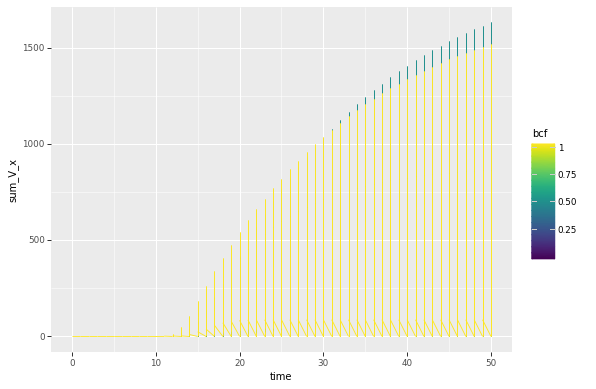

In [18]:
figure = plots_V[0]
figure.savefig()